<a href="https://colab.research.google.com/github/open-neuromorphic/fpga-snntorch/blob/main/software/ISFPGA_SNN_cheatsheet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>





[<img src='https://github.com/jeshraghian/snntorch/blob/master/docs/_static/img/snntorch_alpha_w.png?raw=true' width="200">]

In [85]:
!pip install snntorch --quiet # shift + enter

*What will I learn?*

1. Train an SNN classifier using snnTorch
2. Hardware Friendly Training
  - Weight Quantization with Brevitas
  - Stateful Quantization
3. Handling neuromorphic data with Tonic

# 1. Train an SNN Classifier using snnTorch
## 1.1 Imports


In [86]:
# snntorch imports
import snntorch as snn
from snntorch import functional as SF

# pytorch imports
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

# data manipulation
import numpy as np
import itertools

# plotting
import matplotlib.pyplot as plt
from IPython.display import HTML

## 1.2 Boilerplate: DataLoading the MNIST Dataset

In [87]:
# dataloader arguments
batch_size = 128
data_path='/home/markblz/Documents/aventura-politecnica/tcc/repositories/fpga-snntorch/datamnist'

dtype = torch.float
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
## if you're on M1 or M2 GPU:
# device = torch.device("mps")

In [88]:
# Define a transform
transform = transforms.Compose([
            transforms.Resize((28, 28)),
            transforms.Grayscale(),
            transforms.ToTensor(),
            transforms.Normalize((0,), (1,))])

mnist_train = datasets.MNIST(data_path, train=True, download=True, transform=transform)
mnist_test = datasets.MNIST(data_path, train=False, download=True, transform=transform)

In [89]:
# Create DataLoaders
train_loader = DataLoader(mnist_train, batch_size=batch_size, shuffle=True, drop_last=True)
test_loader = DataLoader(mnist_test, batch_size=batch_size, shuffle=True, drop_last=True)

## 1.3 Construct SNN Model

In [90]:
# Network Architecture
num_inputs = 28*28
num_hidden = 100
num_outputs = 10

# Temporal Dynamics
num_steps = 25
beta = 0.95

In [91]:
from snntorch import surrogate

# Define Network
class Net(nn.Module):
    def __init__(self):
        super().__init__()

        # Initialize layers
        self.fc1 = nn.Linear(num_inputs, num_hidden)
        self.lif1 = snn.Leaky(beta=beta)
        self.fc2 = nn.Linear(num_hidden, num_outputs)
        self.lif2 = snn.Leaky(beta=beta)

    def forward(self, x):

        # Initialize hidden states at t=0
        mem1 = self.lif1.init_leaky()
        mem2 = self.lif2.init_leaky()

        # Record the final layer
        spk2_rec = []
        mem2_rec = []

        # time-loop
        for step in range(num_steps):
          cur1 = self.fc1(x.flatten(1)) # batch: 128 x 784
          spk1, mem1 = self.lif1(cur1, mem1)
          cur2 = self.fc2(spk1)
          spk2, mem2 = self.lif2(cur2, mem2)

          # store in list
          spk2_rec.append(spk2)
          mem2_rec.append(mem2)

        return torch.stack(spk2_rec, dim=0), torch.stack(mem2_rec, dim=0) # time-steps x batch x num_out

# Load the network onto CUDA if available
net = Net().to(device)

## 1.4 Training the SNN

In [92]:
def training_loop(model, dataloader, num_epochs=1):
  loss = nn.CrossEntropyLoss()
  optimizer = torch.optim.Adam(model.parameters(), lr=5e-4, betas=(0.9, 0.999))
  counter = 0

  # Outer training loop
  for epoch in range(num_epochs):
      train_batch = iter(dataloader)

      # Minibatch training loop
      for data, targets in train_batch:
          data = data.to(device)
          targets = targets.to(device)

          # forward pass
          model.train()
          spk_rec, _ = model(data)

          # initialize the loss & sum over time
          loss_val = torch.zeros((1), dtype=dtype, device=device)
          loss_val = loss(spk_rec.sum(0), targets) # batch x num_out

          # Gradient calculation + weight update
          optimizer.zero_grad()
          loss_val.backward()
          optimizer.step()

          # Print train/test loss/accuracy
          if counter % 10 == 0:
              print(f"Iteration: {counter} \t Train Loss: {loss_val.item()}")
          counter += 1

          if counter == 100:
            break

training_loop(net, train_loader)

Iteration: 0 	 Train Loss: 2.879148483276367
Iteration: 10 	 Train Loss: 1.7492191791534424
Iteration: 20 	 Train Loss: 1.002739667892456
Iteration: 30 	 Train Loss: 0.7407540082931519
Iteration: 40 	 Train Loss: 0.546580970287323
Iteration: 50 	 Train Loss: 0.4311913549900055
Iteration: 60 	 Train Loss: 0.42761972546577454
Iteration: 70 	 Train Loss: 0.42054569721221924
Iteration: 80 	 Train Loss: 0.28292006254196167
Iteration: 90 	 Train Loss: 0.3378041684627533


In [93]:
def measure_accuracy(model, dataloader):
  with torch.no_grad():
    model.eval()
    running_length = 0
    running_accuracy = 0

    for data, targets in iter(dataloader):
      data = data.to(device)
      targets = targets.to(device)

      # forward-pass
      spk_rec, _ = model(data)
      spike_count = spk_rec.sum(0) # batch x num_outputs
      _, max_spike = spike_count.max(1)

      # correct classes for one batch
      num_correct = (max_spike == targets).sum()

      # total accuracy
      running_length += len(targets)
      running_accuracy += num_correct

    accuracy = (running_accuracy / running_length)

    return accuracy.item()


In [94]:
print(f"Test set accuracy: {measure_accuracy(net, test_loader)}")

Test set accuracy: 0.9117588400840759


### A Sanity Check

In [95]:
def print_sample(model, dataloader, idx=0):
  with torch.no_grad():
    model.eval()

    data, targets = next(iter(dataloader))
    data = data.to(device)
    targets = targets.to(device)

    # forward-pass
    spk_rec, _ = model(data)
    spike_count = spk_rec.sum(0) # batch x num_outputs
    _, max_spike = spike_count.max(1)

    # Plot the sample
    plt.imshow(data[idx].cpu().squeeze(), cmap='gray')
    plt.title(f'Target: {targets[idx].item()}')
    plt.show()


    return

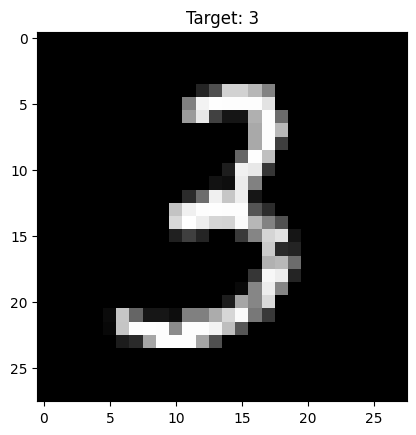

In [96]:
print_sample(net, test_loader)

# 2. Hardware Friendly Training
## 2.1 Weight Quantization

In [97]:
!pip install brevitas --quiet

Just replace all `nn.Linear` layers with `qnn.QuantLinear(num_inputs, num_outputs, weight_bit_width, bias)`.

In [98]:
import brevitas.nn as qnn

# Define Network
class QuantNet(nn.Module):
    def __init__(self):
        super().__init__()

        # Initialize layers
        self.fc1 = qnn.QuantLinear(num_inputs, num_hidden, weight_bit_width=8, bias=False)
        self.lif1 = snn.Leaky(beta=beta)
        self.fc2 = qnn.QuantLinear(num_hidden, num_outputs, weight_bit_width=8, bias=False)
        self.lif2 = snn.Leaky(beta=beta)

    def forward(self, x):

        # Initialize hidden states at t=0
        mem1 = self.lif1.init_leaky()
        mem2 = self.lif2.init_leaky()

        # Record the final layer
        spk2_rec = []
        mem2_rec = []

        for step in range(num_steps):
            cur1 = self.fc1(x.flatten(1))
            spk1, mem1 = self.lif1(cur1, mem1)
            cur2 = self.fc2(spk1)
            spk2, mem2 = self.lif2(cur2, mem2)
            spk2_rec.append(spk2)
            mem2_rec.append(mem2)

        return torch.stack(spk2_rec, dim=0), torch.stack(mem2_rec, dim=0)

# Load the network onto CUDA if available
qnet = QuantNet().to(device)

In [99]:
training_loop(qnet, train_loader)
print(f"Test set accuracy: {measure_accuracy(qnet, test_loader)}")

Iteration: 0 	 Train Loss: 2.5612916946411133
Iteration: 10 	 Train Loss: 1.7607202529907227
Iteration: 20 	 Train Loss: 1.1101235151290894
Iteration: 30 	 Train Loss: 0.6506174206733704
Iteration: 40 	 Train Loss: 0.4861527681350708
Iteration: 50 	 Train Loss: 0.3326822519302368
Iteration: 60 	 Train Loss: 0.3528664708137512
Iteration: 70 	 Train Loss: 0.36740225553512573
Iteration: 80 	 Train Loss: 0.32880255579948425
Iteration: 90 	 Train Loss: 0.29565346240997314
Test set accuracy: 0.9123597741127014


## 2.2 SQUAT: Stateful Quantization-Aware Training



In [117]:
# Network Architecture
num_inputs = 28*28 # 784
num_hidden = 10
num_outputs = 10

# Temporal Dynamics
num_steps = 25
beta = 0.95

In [118]:
from snntorch.functional import quant

# Define Network
class SquatNet(nn.Module):
    def __init__(self):
        super().__init__()

        q_lif = quant.state_quant(num_bits=4, uniform=True)

        # Initialize layers
        self.fc1 = qnn.QuantLinear(num_inputs, num_hidden, weight_bit_width=8, bias=False)
        self.lif1 = snn.Leaky(beta=beta, state_quant=q_lif)
        self.fc2 = qnn.QuantLinear(num_hidden, num_outputs, weight_bit_width=8, bias=False)
        self.lif2 = snn.Leaky(beta=beta, state_quant=q_lif)
        
    def forward(self, x):
        
        # print(f"x shape: {x.shape}")
        # Initialize hidden states at t=0
        mem1 = self.lif1.init_leaky()
        mem2 = self.lif2.init_leaky()

        # Record the final layer
        spk2_rec = []
        mem2_rec = []

        for step in range(num_steps):
            cur1 = self.fc1(x.flatten(1))
            spk1, mem1 = self.lif1(cur1, mem1)
            cur2 = self.fc2(spk1)
            spk2, mem2 = self.lif2(cur2, mem2)
            spk2_rec.append(spk2)
            mem2_rec.append(mem2)

        return torch.stack(spk2_rec, dim=0), torch.stack(mem2_rec, dim=0)

# Load the network onto CUDA if available
sqnet = SquatNet().to(device)

In [119]:

training_loop(sqnet, train_loader)
print(f"Test set accuracy: {measure_accuracy(sqnet, test_loader)}")

Iteration: 0 	 Train Loss: 2.37388014793396
Iteration: 10 	 Train Loss: 2.0580670833587646
Iteration: 20 	 Train Loss: 1.954564094543457
Iteration: 30 	 Train Loss: 1.5086618661880493
Iteration: 40 	 Train Loss: 1.4088497161865234
Iteration: 50 	 Train Loss: 1.383249044418335
Iteration: 60 	 Train Loss: 1.0730491876602173
Iteration: 70 	 Train Loss: 1.1895477771759033
Iteration: 80 	 Train Loss: 0.8146205544471741
Iteration: 90 	 Train Loss: 0.9568356871604919
Test set accuracy: 0.743990421295166


In [103]:
torch.save(sqnet.state_dict(), 'snn_model_weights.pth')


In [104]:
state_dict = torch.load('snn_model_weights.pth', map_location=device)


/tmp/ipykernel_153264/3307253767.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load('snn_model_weights.pth', map_location=device)


In [105]:
fc1_weight = state_dict['fc1.weight'].cpu().numpy()
fc2_weight = state_dict['fc2.weight'].cpu().numpy()

print(fc1_weight.shape)

(100, 784)


In [106]:
import numpy as np

# Quantize the weights
def quantize_fixed_point(weights, integer_bits, fractional_bits):
    total_bits = integer_bits + fractional_bits
    scale_factor = 2 ** fractional_bits
    max_int = 2 ** (total_bits - 1) - 1
    min_int = -2 ** (total_bits - 1)
    
    # Escalar os pesos
    weights_scaled = weights * scale_factor
    
    # Arredondar para o inteiro mais próximo
    weights_quantized = np.round(weights_scaled)
    
    # Clampar os valores para o intervalo permitido
    weights_clamped = np.clip(weights_quantized, min_int, max_int)
    
    # Converter para tipo inteiro adequado
    weights_fixed_point = weights_clamped.astype(np.int8)
    
    return weights_fixed_point


In [69]:
# Quantize the weights
integer_bits = 4
fractional_bits = 4 

fc1_weight_q = quantize_fixed_point(fc1_weight, integer_bits, fractional_bits)
fc2_weight_q = quantize_fixed_point(fc2_weight, integer_bits, fractional_bits)

np.savetxt('fc1_weight_q.txt', fc1_weight_q, fmt='%d', delimiter=',')
np.savetxt('fc2_weight_q.txt', fc2_weight_q, fmt='%d', delimiter=',')



In [70]:
# Print the shapes
fc1_shape = fc1_weight_q.shape  # (num_hidden, num_inputs)
fc2_shape = fc2_weight_q.shape  # (num_outputs, num_hidden)

print(fc1_shape)
print(fc2_shape)

(100, 784)
(10, 100)


In [71]:
# Abrir um arquivo para escrever o código do HLS
with open('fc1_weight_array.txt', 'w') as f:
    f.write('const int fc1_weight[NUM_HIDDEN][NUM_INPUTS] = {\n')
    for row in fc1_weight_q:
        # Converter cada linha em uma string com valores separados por vírgula
        row_str = ', '.join(map(str, row.astype(int)))
        # Escrever a linha com chaves e vírgula
        f.write('    { ' + row_str + ' },\n')
    f.write('};\n')

    # Abrir um arquivo para escrever o código
with open('fc2_weight_array.txt', 'w') as f:
    f.write('const int fc2_weight[NUM_OUTPUTS][NUM_HIDDEN] = {\n')
    for row in fc2_weight_q:
        f.write('    { ' + ', '.join(map(str, row.astype(int))) + ' },\n')
    f.write('};\n')

In [72]:
# Escrever o código VHDL para os pesos
with open('fc1_weight_vhdl.txt', 'w') as f:
    f.write("constant WEIGHTS : weight_matrix := (\n")
    for i, row in enumerate(fc1_weight_q):
        row_str = ', '.join(str(w) for w in row)
        if i < len(fc1_weight_q) - 1:
            f.write(f"    ( {row_str} ),\n")
        else:
            f.write(f"    ( {row_str} )\n")
    f.write(");\n")

with open('fc2_weight_vhdl.txt', 'w') as f:
    f.write("constant WEIGHTS : weight_matrix := (\n")
    for i, row in enumerate(fc2_weight_q):
        row_str = ', '.join(str(w) for w in row)
        if i < len(fc2_weight_q) - 1:
            f.write(f"    ( {row_str} ),\n")
        else:
            f.write(f"    ( {row_str} )\n")
    f.write(");\n")


In [73]:
# Escrever o valor do fator de escala
scale_factor = 2 ** fractional_bits
with open('scales.txt', 'w') as f:
    f.write(f'scale_factor: {scale_factor}\n')

In [74]:
# Salvar o valor de beta
beta = 0.95
beta_q = int(beta * scale_factor)
with open('beta_q.txt', 'w') as f:
    f.write(f'{beta_q}')


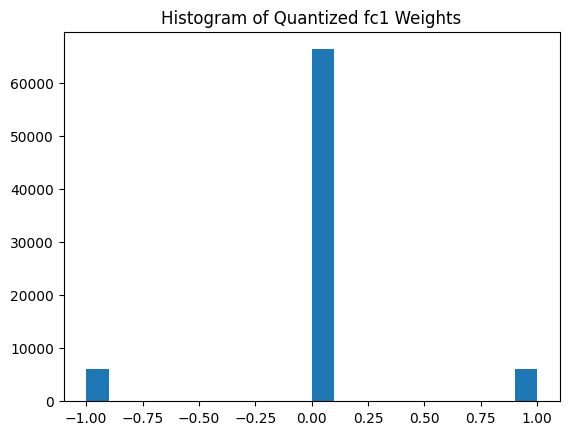

In [75]:
# Plot the histogram of the quantized weights
import matplotlib.pyplot as plt

plt.hist(fc1_weight_q.flatten(), bins=20)
plt.title('Histogram of Quantized fc1 Weights')
plt.show()


In [76]:
# Substituir os pesos do modelo pelos quantizados
sqnet.fc1.weight.data = torch.tensor(fc1_weight_q / scale_factor, dtype=torch.float32).to(device)
sqnet.fc2.weight.data = torch.tensor(fc2_weight_q / scale_factor, dtype=torch.float32).to(device)

# Testar a acurácia
print(f"Acurácia com pesos quantizados: {measure_accuracy(sqnet, test_loader)}")


Acurácia com pesos quantizados: 0.8269230723381042


# 3. Handling Neuromorphic Data with Tonic

In [77]:
!pip install tonic --quiet

## 3.1 PokerDVS Dataset

The dataset used in this tutorial is POKERDVS by T. Serrano-Gotarredona and B. Linares-Barranco:

```
Serrano-Gotarredona, Teresa, and Bernabé Linares-Barranco. "Poker-DVS and MNIST-DVS. Their history, how they were made, and other details." Frontiers in neuroscience 9 (2015): 481.
```

It is comprised of four classes, each being a suite of a playing card deck: clubs, spades, hearts, and diamonds. The data consists of 131 poker pip symbols, and was collected by flipping poker cards in front of a DVS128 camera.

[(    0, 20, 21, 0) (  106, 21, 19, 0) (  146, 13,  9, 1) ...
 (15365, 13, 17, 1) (15384, 16, 16, 1) (15408, 16, 22, 0)]


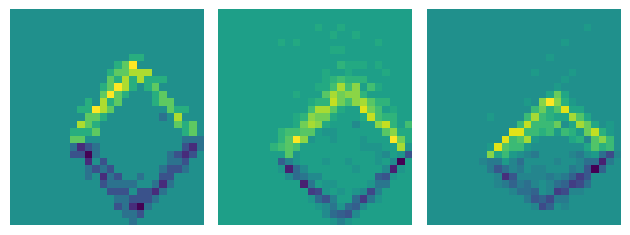

In [78]:
import tonic

poker_train = tonic.datasets.POKERDVS(save_to='./data', train=True)
poker_test = tonic.datasets.POKERDVS(save_to='./data', train=False)

events, target = poker_train[0]
print(events)
tonic.utils.plot_event_grid(events)

In [79]:
import tonic.transforms as transforms
from tonic import DiskCachedDataset

# time_window
frame_transform = tonic.transforms.Compose([tonic.transforms.Denoise(filter_time=10000),
                                            tonic.transforms.ToFrame(
                                            sensor_size=tonic.datasets.POKERDVS.sensor_size,
                                            time_window=1000)
                                            ])

batch_size = 8
cached_trainset = DiskCachedDataset(poker_train, transform=frame_transform, cache_path='./cache/pokerdvs/train')
cached_testset = DiskCachedDataset(poker_test, transform=frame_transform, cache_path='./cache/pokerdvs/test')

train_loader = DataLoader(cached_trainset, batch_size=batch_size, collate_fn=tonic.collation.PadTensors(batch_first=False), shuffle=True)
test_loader = DataLoader(cached_testset, batch_size=batch_size, collate_fn=tonic.collation.PadTensors(batch_first=False), shuffle=True)

data, labels = next(iter(train_loader))
print(data.size())
print(labels)

torch.Size([17, 8, 2, 35, 35])
tensor([0, 1, 1, 2, 2, 1, 3, 1])


In [80]:
import torch.functional as F

# Define Network
class DVSNet(nn.Module):
    def __init__(self):
        super().__init__()

        beta = 0.9

        # Initialize layers
        self.conv1  = nn.Conv2d(2, 12, 5)
        self.mp1    = nn.MaxPool2d(2)
        self.lif1   = snn.Leaky(beta=beta)
        self.conv2  = nn.Conv2d(12, 32, 5)
        self.mp2    = nn.MaxPool2d(2)
        self.lif2   = snn.Leaky(beta=beta)
        self.fc     = nn.Linear(32*5*5, 4)
        self.lif3   = snn.Leaky(beta=beta)


    def forward(self, x):

        # Initialize hidden states at t=0
        mem1 = self.lif1.init_leaky()
        mem2 = self.lif2.init_leaky()
        mem3 = self.lif3.init_leaky()

        # Record the final layer
        spk3_rec = []
        mem3_rec = []

        for step in range(x.size(0)):
            cur1       = self.mp1(self.conv1(x[step]))
            spk1, mem1 = self.lif1(cur1, mem1)
            cur2       = self.mp2(self.conv2(spk1))
            spk2, mem2 = self.lif2(cur2, mem2)
            cur3       = self.fc(spk2.flatten(1))
            spk3, mem3 = self.lif3(cur3, mem3)

            spk3_rec.append(spk3)
            mem3_rec.append(mem3)

        return torch.stack(spk3_rec, dim=0), torch.stack(mem3_rec, dim=0)

# Load the network onto CUDA if available
dvsnet = DVSNet().to(device)

In [81]:
training_loop(dvsnet, train_loader, num_epochs=10)
print(f"Test set accuracy: {measure_accuracy(dvsnet, test_loader)}")

Iteration: 0 	 Train Loss: 1.3862943649291992
Iteration: 10 	 Train Loss: 1.401853084564209
Iteration: 20 	 Train Loss: 0.6059767007827759
Iteration: 30 	 Train Loss: 0.493002325296402
Iteration: 40 	 Train Loss: 0.3848695755004883
Iteration: 50 	 Train Loss: 0.24776677787303925
Test set accuracy: 1.0


That's all folks!